In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import os
import shutil
import cv2

# Attribute mapping

## 1. Analysis

### 1.1 Project Description 

This project aims to develop a machine learning model capable of identifying grocery products and categorizing them based on their images. The model will analyze product images to classify items such as fruits, vegetables, beverages, and packaged goods into predefined categories. 

### 1.2 Business Objective Definition

Our solution aims to enhance Stibo Systems' Master Data Management (MDM) capabilities by integrating advanced image recognition technology to automatically identify and categorize customer products based on images provided by their clients. This innovation will streamline product classification processes, ensuring greater accuracy and efficiency. By empowering Stibo Systems to offer a more intelligent and automated approach to product data management, the solution supports practical use cases such as improved inventory management, retail automation, and enhanced consumer convenience, while also enabling applications like automatic checkout, product cataloging, and stock monitoring. 

### 1.3 Framing the problem
The problem is a supervised learning classification task, where the model takes a picture of a grocery item, identifies it and maps it into its category. Labeled datasets containing images and corresponding category labels are used to train the model. A classification model would seem like a good fit for classifying an image to the item’s name and category. 

The target audience includes Stibo Systems and their clients, who rely on accurate and automated product categorization for harmonizing data across multiple sources in their MDM-systems. While the initial focus is on grocery products, the ultimate goal is to develop a scalable solution that can extend to any product category, providing a versatile tool for data management needs. 


### 1.4 Performance Metrics 

In our project, we will evaluate the performance of the model using a combination of precision, recall, F1-score, and top-k accuracy to ensure a comprehensive assessment of its effectiveness in identifying and categorizing grocery products. 

- Precision will measure the proportion of correctly predicted products in each category out of all predictions for that category. This metric is essential to minimize false positives, ensuring that incorrect categorizations are kept to a minimum. 

- Recall will assess the proportion of correctly identified products in each category out of all actual products in that category. This is particularly important to ensure that the model does not miss relevant products, especially in scenarios where accurate categorization is critical for downstream processes. 

- F1-Score, the harmonic mean of precision and recall, will serve as the primary metric for overall model performance. It provides a balanced measure, particularly useful in scenarios where there is a need to optimize both precision and recall, such as handling imbalanced categories or avoiding bias toward dominant product types. 

- Top-k Accuracy will measure whether the correct category appears within the top-k predictions. This metric is particularly relevant for real-world applications like auto-checkout or cataloging, where the system can suggest multiple likely categories for verification, ensuring practical usability even when the top prediction is incorrect. 

By combining these metrics, we will gain a holistic understanding of the model’s performance and ensure it meets both technical and business requirements effectively. 

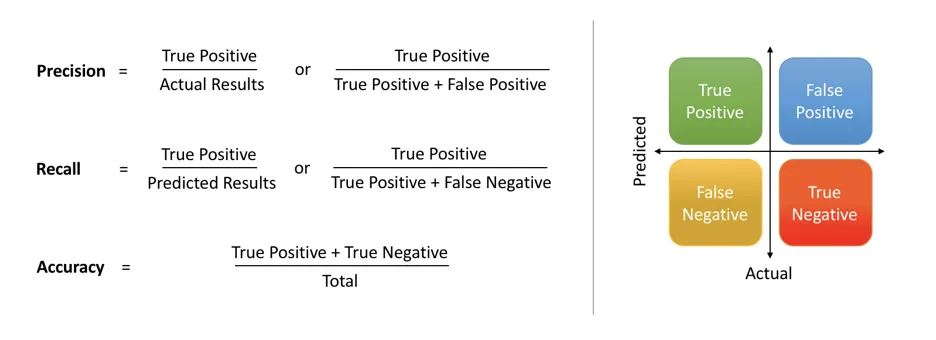

## 2. Data exploration

### 2.1 Data source 

Data for this assignment was found using <a href="https://www.kaggle.com/datasets/amoghmisra27/grocery/data">Kaggle</a>.

### 2.2 Get the data

In [33]:
# Loading datasets
classes = pd.read_csv('GroceryStoreDataset-master/dataset/classes.csv')
classes.head()

Class Name (str)  Class ID (int) Coarse Class Name (str)  \
0  Golden-Delicious               0                   Apple   
1      Granny-Smith               1                   Apple   
2         Pink-Lady               2                   Apple   
3     Red-Delicious               3                   Apple   
4        Royal-Gala               4                   Apple   

   Coarse Class ID (int)                            Iconic Image Path (str)  \
0                      0  /iconic-images-and-descriptions/Fruit/Apple/Go...   
1                      0  /iconic-images-and-descriptions/Fruit/Apple/Gr...   
2                      0  /iconic-images-and-descriptions/Fruit/Apple/Pi...   
3                      0  /iconic-images-and-descriptions/Fruit/Apple/Re...   
4                      0  /iconic-images-and-descriptions/Fruit/Apple/Ro...   

                      Product Description Path (str)  
0  /iconic-images-and-descriptions/Fruit/Apple/Go...  
1  /iconic-images-and-descriptions/Fruit/Apple/Gr...  
2  /iconic-images-and-descriptions/Fruit/Apple/Pi...  
3  /iconic-images-and-descriptions/Fruit/Apple/Re...  
4  /iconic-images-and-descriptions/Fruit/Apple/Ro...

In [34]:
classes['Coarse Class Name (str)'].unique()

array(['Apple', 'Avocado', 'Banana', 'Kiwi', 'Lemon', 'Lime', 'Mango',
       'Melon', 'Nectarine', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach',
       'Pear', 'Pineapple', 'Plum', 'Pomegranate', 'Red-Grapefruit',
       'Satsumas', 'Juice', 'Milk', 'Oatghurt', 'Oat-Milk', 'Sour-Cream',
       'Sour-Milk', 'Soyghurt', 'Soy-Milk', 'Yoghurt', 'Asparagus',
       'Aubergine', 'Cabbage', 'Carrots', 'Cucumber', 'Garlic', 'Ginger',
       'Leek', 'Mushroom', 'Onion', 'Pepper', 'Potato', 'Red-Beet',
       'Tomato', 'Zucchini'], dtype=object)

### 2.3 Size and type of data
The dataset contains natural images of grocery items. All natural images were taken with a smartphone camera in different grocery stores. There are 5125 natural images from 81 different classes of fruits, vegetables, and carton items. The 81 classes are divided into 42 coarse-grained classes, where e.g. the fine-grained classes 'Royal Gala' and 'Granny Smith' belong to the same coarse-grained class 'Apple'.

The dataset contains images predominantly in JPEG format, with dimensions of 348x348 pixels, and utilizing the RGB color mode. These images are organized into subdirectories based on categories, such as "iconic" images representing the products. The consistent image size and format simplify preprocessing and model training, while the structured organization aids in efficient data management and category-specific analysis. 

The dataset is divided into three subsets: 

    Training Set: 2640 images 

    Validation Set: 296 images 

    Test Set: 2485 images 

This distribution of image samples introduces some concerns:
- Imbalanced data distribution: The model might not perform optimally due to an insufficiently large training set. Typically, the training set should be the largest portion of the data to allow the model to learn as comprehensively as possible.
- Overfitting or Underfitting: With a small validation set, there's a risk that the model's tuning is not reflective of its performance on a broader range of data, leading to overfitting (where the model learns the training data too well, including the noise and errors) or underfitting (where the model does not learn the underlying patterns effectively).
- Wasted Data on Testing: While it is good to have a comprehensive test to evaluate the model, the current allocation might be excessive. Reducing the test set and reallocating those images to the training set could provide more learning opportunities without significantly compromising the model’s evaluation.

Further in section 3, we will explore the image sample distribution within the categories and see how we can optimally redistribute the images.

## 3. Explore the data

1. Create a copy of the data for explorations (sampling it down to a manageable size if necessary)
2. Create a Jupyter notebook to keep a record of your data exploration
3. Study each feature and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc)
    * Percentage of missing values
    * Check for outliers, rounding errors etc
4. For supervised learning tasks, identify the target(s)
5. Visualise the data
6. Study the correlations between features
7. Identify the promising transformations you may want to apply (e.g. convert skewed targets to normal via a log transformation)
8. Document what you have learned

### 3.1 Create dataset copies

In [35]:
grocery_items_df = pd.DataFrame(classes)
display(grocery_items_df)

Class Name (str)  Class ID (int) Coarse Class Name (str)  \
0   Golden-Delicious               0                   Apple   
1       Granny-Smith               1                   Apple   
2          Pink-Lady               2                   Apple   
3      Red-Delicious               3                   Apple   
4         Royal-Gala               4                   Apple   
..               ...             ...                     ...   
76          Red-Beet              76                Red-Beet   
77       Beef-Tomato              77                  Tomato   
78    Regular-Tomato              78                  Tomato   
79       Vine-Tomato              79                  Tomato   
80          Zucchini              80                Zucchini   

    Coarse Class ID (int)                            Iconic Image Path (str)  \
0                       0  /iconic-images-and-descriptions/Fruit/Apple/Go...   
1                       0  /iconic-images-and-descriptions/Fruit/Apple/Gr...   
2                       0  /iconic-images-and-descriptions/Fruit/Apple/Pi...   
3                       0  /iconic-images-and-descriptions/Fruit/Apple/Re...   
4                       0  /iconic-images-and-descriptions/Fruit/Apple/Ro...   
..                    ...                                                ...   
76                     40  /iconic-images-and-descriptions/Vegetables/Red...   
77                     41  /iconic-images-and-descriptions/Vegetables/Tom...   
78                     41  /iconic-images-and-descriptions/Vegetables/Tom...   
79                     41  /iconic-images-and-descriptions/Vegetables/Tom...   
80                     42  /iconic-images-and-descriptions/Vegetables/Zuc...   

                       Product Description Path (str)  
0   /iconic-images-and-descriptions/Fruit/Apple/Go...  
1   /iconic-images-and-descriptions/Fruit/Apple/Gr...  
2   /iconic-images-and-descriptions/Fruit/Apple/Pi...  
3   /iconic-images-and-descriptions/Fruit/Apple/Re...  
4   /iconic-images-and-descriptions/Fruit/Apple/Ro...  
..                                                ...  
76  /iconic-images-and-descriptions/Vegetables/Red...  
77  /iconic-images-and-descriptions/Vegetables/Tom...  
78  /iconic-images-and-descriptions/Vegetables/Tom...  
79  /iconic-images-and-descriptions/Vegetables/Tom...  
80  /iconic-images-and-descriptions/Vegetables/Zuc...  

[81 rows x 6 columns]

### 3.2 Features and their characteristics

In [36]:
grocery_items_df.columns

Index(['Class Name (str)', 'Class ID (int)', 'Coarse Class Name (str)',
       'Coarse Class ID (int)', 'Iconic Image Path (str)',
       'Product Description Path (str)'],
      dtype='object')

In the output above, we can see that there are 6 features:
- Class Name (str) - e.g. 'Golden-Delicious', 'Pink-Lady'
- Class ID (int) - 0 to 80, as there are 81 classes
- Coarse Class Name (str) - e.g. 'Apple', 'Tomato' - category for each class
- Coarse Class ID (int) - 0 to 42, as there are 43 coarse classes
- Iconic Image Path (str) - file path to the picture in JPG format
- Product Description Path (str) - filepath to the grocery product's description in txt file

To make the features more understandable, we rename 'Coarse Class Name (str)' to 'Category Name (str)' and 'Coarse Class ID (int)' to 'Category ID (int)'


In [37]:
# rename column 'Coarse Class Name (str)' to 'Category Name'
grocery_items_df.rename(columns = {'Coarse Class Name (str)':'Category Name (str)'}, inplace = True)
grocery_items_df.rename(columns = {'Coarse Class ID (int)':'Category ID (int)'}, inplace = True)
display(grocery_items_df)

Class Name (str)  Class ID (int) Category Name (str)  Category ID (int)  \
0   Golden-Delicious               0               Apple                  0   
1       Granny-Smith               1               Apple                  0   
2          Pink-Lady               2               Apple                  0   
3      Red-Delicious               3               Apple                  0   
4         Royal-Gala               4               Apple                  0   
..               ...             ...                 ...                ...   
76          Red-Beet              76            Red-Beet                 40   
77       Beef-Tomato              77              Tomato                 41   
78    Regular-Tomato              78              Tomato                 41   
79       Vine-Tomato              79              Tomato                 41   
80          Zucchini              80            Zucchini                 42   

                              Iconic Image Path (str)  \
0   /iconic-images-and-descriptions/Fruit/Apple/Go...   
1   /iconic-images-and-descriptions/Fruit/Apple/Gr...   
2   /iconic-images-and-descriptions/Fruit/Apple/Pi...   
3   /iconic-images-and-descriptions/Fruit/Apple/Re...   
4   /iconic-images-and-descriptions/Fruit/Apple/Ro...   
..                                                ...   
76  /iconic-images-and-descriptions/Vegetables/Red...   
77  /iconic-images-and-descriptions/Vegetables/Tom...   
78  /iconic-images-and-descriptions/Vegetables/Tom...   
79  /iconic-images-and-descriptions/Vegetables/Tom...   
80  /iconic-images-and-descriptions/Vegetables/Zuc...   

                       Product Description Path (str)  
0   /iconic-images-and-descriptions/Fruit/Apple/Go...  
1   /iconic-images-and-descriptions/Fruit/Apple/Gr...  
2   /iconic-images-and-descriptions/Fruit/Apple/Pi...  
3   /iconic-images-and-descriptions/Fruit/Apple/Re...  
4   /iconic-images-and-descriptions/Fruit/Apple/Ro...  
..                                                ...  
76  /iconic-images-and-descriptions/Vegetables/Red...  
77  /iconic-images-and-descriptions/Vegetables/Tom...  
78  /iconic-images-and-descriptions/Vegetables/Tom...  
79  /iconic-images-and-descriptions/Vegetables/Tom...  
80  /iconic-images-and-descriptions/Vegetables/Zuc...  

[81 rows x 6 columns]

To continue the data exploration, we will check how many items there are per category, to get a better understanding of the scope.

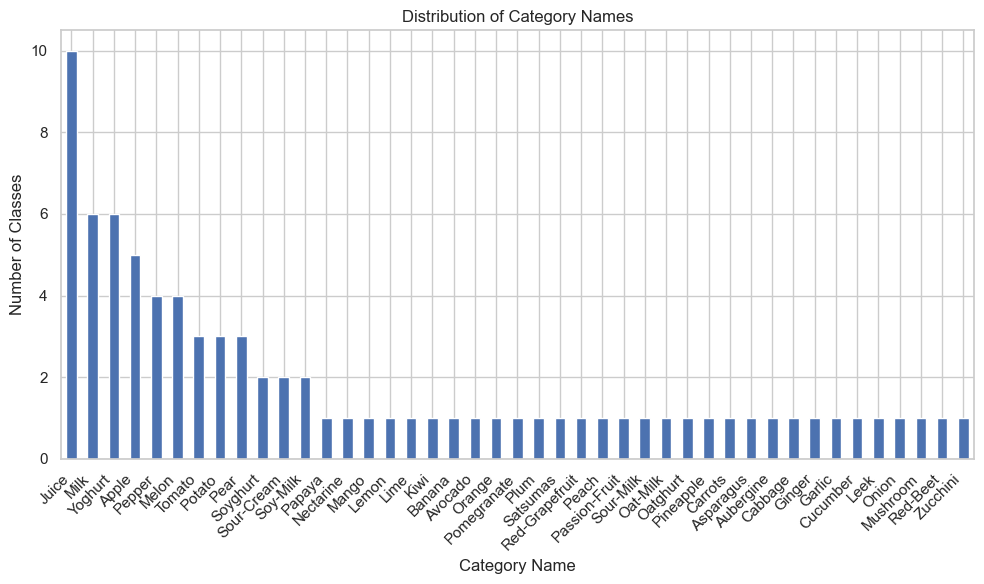

In [38]:
# Count the number of fine-grained classes in each coarse class
category_counts = grocery_items_df["Category Name (str)"].value_counts()

# Plot the distribution of classes in each category
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', title='Distribution of Category Names')
plt.xlabel('Category Name')
plt.ylabel('Number of Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Let's look at how many images there are per class in each train, test, and validation data set. To see this, we randomly choose a category - 'Juice', since it has the most classes.

In [39]:
train_file = 'GroceryStoreDataset-master/dataset/train.txt'
val_file = 'GroceryStoreDataset-master/dataset/val.txt'
test_file = 'GroceryStoreDataset-master/dataset/test.txt'

def count_images_by_classes(file_path, class_list):
    count = 0
    with open(file_path, 'r') as file:
        for line in file:
            image_path = line.strip().split()[0]
            if any(cls in image_path for cls in class_list):
                count += 1
    return count

In [40]:
# Filtering for juice-related classes
juice_data = grocery_items_df[grocery_items_df['Category Name (str)'].str.contains("Juice", case=False, na=False)]

# Get unique classes of juices
juice_classes = juice_data['Class Name (str)'].unique()

# Prepare a DataFrame to hold the counts
columns = ['Juice Variety', 'Train', 'Validation', 'Test']
data = []

for juice in juice_classes:
    juice_list = juice_data[juice_data['Class Name (str)'].str.contains(juice, case=False, na=False)]['Class Name (str)'].tolist()

    # Count images for each dataset split
    train_count = count_images_by_classes(train_file, juice_list)
    val_count = count_images_by_classes(val_file, juice_list)
    test_count = count_images_by_classes(test_file, juice_list)

    data.append([juice, train_count, val_count, test_count])

juice_distribution_df = pd.DataFrame(data, columns=columns)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot data
plt.figure(figsize=(10, 6))
juice_plot = sns.barplot(x='Juice Variety', y='value', hue='variable', data=pd.melt(juice_distribution_df, ['Juice Variety']))

# Enhance plot aesthetics
juice_plot.set_title('Distribution of Juice Images Across Dataset Splits')
juice_plot.set_xlabel('Juice Varieties')
juice_plot.set_ylabel('Number of Images')
plt.xticks(rotation=45)  # Rotate class labels for better readability

# Show the plot
plt.show()



KeyboardInterrupt: 

As we also observed in section 2.3, the image samples aren't optimally distributed, resulting in max 50% for the training set, 6% for the validation set, and 45% for the testing set. 
Our aim is:
- Training Set: About 70-80% of the data (ideally around 3795 to 4337 images).
- Validation Set: About 10-15% of the data (ideally around 542 to 813 images).
- Test Set: About 10-15% of the data (ideally around 542 to 813 images).

Therefore, we will redistribute the samples in each class to ensure following the 60/20/20 rule of dataset distribution.


Restribution of test, validation and train data

In [ ]:
from collections import defaultdict
import random
import pandas as pd

all_classes = grocery_items_df['Class Name (str)'].tolist()

# Stratified reallocation function
def stratified_reallocate_splits(train_file, val_file, test_file, class_names, new_train_ratio=0.6, new_val_ratio=0.2, new_test_ratio=0.2):
    # Load the current splits
    with open(train_file, 'r') as f:
        train_data = f.readlines()
    with open(val_file, 'r') as f:
        val_data = f.readlines()
    with open(test_file, 'r') as f:
        test_data = f.readlines()

    # Combine all data
    all_data = train_data + val_data + test_data

    # Group data by categories
    category_data = defaultdict(list)
    for line in all_data:
        for class_name in class_names:
            if class_name in line:
                category_data[class_name].append(line)
                break

    # Create new splits
    new_train_data, new_val_data, new_test_data = [], [], []

    for category, items in category_data.items():
        random.shuffle(items)
        total = len(items)
        train_size = int(total * new_train_ratio)
        val_size = int(total * new_val_ratio)

        new_train_data.extend(items[:train_size])
        new_val_data.extend(items[train_size:train_size + val_size])
        new_test_data.extend(items[train_size + val_size:])

    # Save the new splits to files
    with open('GroceryStoreDataset-working/dataset/train.txt', 'w') as f:
        f.writelines(new_train_data)
    with open('GroceryStoreDataset-working/dataset/val.txt', 'w') as f:
        f.writelines(new_val_data)
    with open('GroceryStoreDataset-working/dataset/test.txt', 'w') as f:
        f.writelines(new_test_data)

    return len(new_train_data), len(new_val_data), len(new_test_data)

# Apply stratified reallocation across all classes
new_train_count, new_val_count, new_test_count = stratified_reallocate_splits(
    train_file, val_file, test_file, all_classes, new_train_ratio=0.6, new_val_ratio=0.2, new_test_ratio=0.2
)

print(f"New Train Count: {new_train_count}")
print(f"New Validation Count: {new_val_count}")
print(f"New Test Count: {new_test_count}")

New Train Count: 3220
New Validation Count: 1055
New Test Count: 1146


Recalculate the distribution of each category in the new splits and compare it with the original distribution to ensure proportions are preserved.

In [ ]:
from collections import Counter

# Function to count category occurrences in a file
def count_categories(split_file, class_names):
    category_counts = Counter()
    with open(split_file, 'r') as f:
        for line in f:
            for class_name in class_names:
                if class_name in line:
                    category_counts[class_name] += 1
                    break
    return category_counts

# Count categories in the new splits
new_train_category_counts = count_categories('GroceryStoreDataset-working/dataset/train.txt', all_classes)
new_val_category_counts = count_categories('GroceryStoreDataset-working/dataset/val.txt', all_classes)
new_test_category_counts = count_categories('GroceryStoreDataset-working/dataset/test.txt', all_classes)

# Display the distributions
print("New Training Set Distribution:", new_train_category_counts)
print("New Validation Set Distribution:", new_val_category_counts)
print("New Test Set Distribution:", new_test_category_counts)

New Training Set Distribution: Counter({'Orange': 202, 'Satsumas': 85, 'Royal-Gala': 80, 'Granny-Smith': 73, 'Pink-Lady': 73, 'Red-Grapefruit': 70, 'Red-Delicious': 60, 'Watermelon': 58, 'Regular-Tomato': 58, 'Golden-Delicious': 57, 'Banana': 57, 'Kiwi': 57, 'Conference': 56, 'Carrots': 54, 'Vine-Tomato': 54, 'Lemon': 52, 'Avocado': 51, 'Cantaloupe': 50, 'Arla-Natural-Yoghurt': 49, 'Brown-Cap-Mushroom': 49, 'Yellow-Onion': 48, 'Peach': 46, 'Honeydew-Melon': 45, 'Anjou': 45, 'Garant-Ecological-Medium-Fat-Milk': 45, 'Arla-Medium-Fat-Milk': 43, 'Red-Bell-Pepper': 43, 'Galia-Melon': 42, 'Nectarine': 42, 'Yoggi-Strawberry-Yoghurt': 41, 'Oatly-Natural-Oatghurt': 40, 'Oatly-Oat-Milk': 40, 'Valio-Vanilla-Yoghurt': 40, 'Lime': 39, 'Mango': 39, 'Arla-Standard-Milk': 39, 'Zucchini': 38, 'Arla-Ecological-Medium-Fat-Milk': 37, 'Passion-Fruit': 36, 'Alpro-Blueberry-Soyghurt': 36, 'Alpro-Shelf-Soy-Milk': 36, 'Arla-Mild-Vanilla-Yoghurt': 36, 'Cucumber': 36, 'Sweet-Potato': 36, 'Kaiser': 35, 'Tropicana

Plotting the redestributed juice data to take alook at how many images there are per class in each train, test, and validation data set after redistributing. 

In [ ]:
new_train_file = 'GroceryStoreDataset-working/dataset/train.txt'
new_val_file = 'GroceryStoreDataset-working/dataset/val.txt'
new_test_file = 'GroceryStoreDataset-working/dataset/test.txt'

def count_images_by_classes_redistributed(file_path, class_list):
    count = 0
    with open(file_path, 'r') as file:
        for line in file:
            image_path = line.strip().split()[0]
            if any(cls in image_path for cls in class_list):
                count += 1
    return count

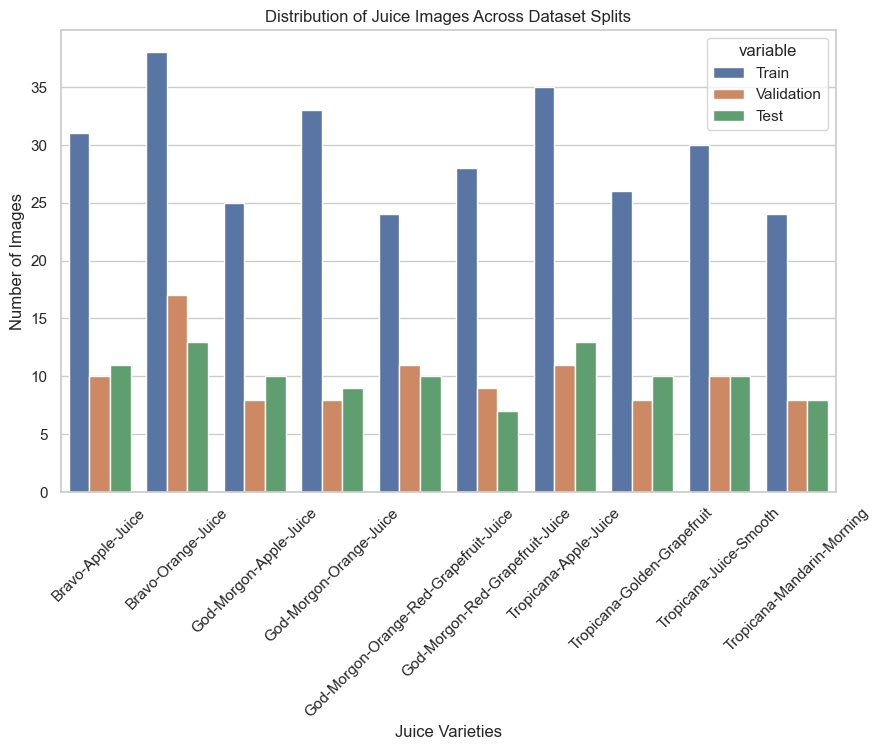

In [ ]:
# Filtering for juice-related classes
juice_data = grocery_items_df[grocery_items_df['Category Name (str)'].str.contains("Juice", case=False, na=False)]

# Get unique classes of juices
juice_classes = juice_data['Class Name (str)'].unique()

# Prepare a DataFrame to hold the counts
columns = ['Juice Variety', 'Train', 'Validation', 'Test']
data = []

for juice in juice_classes:
    juice_list = juice_data[juice_data['Class Name (str)'].str.contains(juice, case=False, na=False)]['Class Name (str)'].tolist()

    # Count images for each dataset split
    new_train_count = count_images_by_classes_redistributed(new_train_file, juice_list)
    new_val_count = count_images_by_classes_redistributed(new_val_file, juice_list)
    new_test_count = count_images_by_classes_redistributed(new_test_file, juice_list)

    data.append([juice, new_train_count, new_val_count, new_test_count])

juice_distribution_df = pd.DataFrame(data, columns=columns)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot data
plt.figure(figsize=(10, 6))
juice_plot = sns.barplot(x='Juice Variety', y='value', hue='variable', data=pd.melt(juice_distribution_df, ['Juice Variety']))

# Enhance plot aesthetics
juice_plot.set_title('Distribution of Juice Images Across Dataset Splits')
juice_plot.set_xlabel('Juice Varieties')
juice_plot.set_ylabel('Number of Images')
plt.xticks(rotation=45)  # Rotate class labels for better readability

# Show the plot
plt.show()

  Percentage of missing values
  
  The results indicate that there are no missing values in any columns, ensuring the dataset is fully populated and reliable for analysis.
  
  
  Additionally, no duplicate rows were detected, confirming that the dataset is free from redundancy. This clean and well-structured dataset provides a solid foundation for building and training our models.

In [ ]:
# Check for missing data in the `grocery_items_df` DataFrame
missing_data_summary = grocery_items_df.isnull().sum()

# Create a summary DataFrame for better readability
missing_data_df = pd.DataFrame({
    "Column": missing_data_summary.index,
    "Missing Count": missing_data_summary.values,
    "Missing Percentage": (missing_data_summary.values / len(grocery_items_df)) * 100
}).sort_values(by="Missing Count", ascending=False)

missing_data_df

Column  Missing Count  Missing Percentage
0                Class Name (str)              0                 0.0
1                  Class ID (int)              0                 0.0
2             Category Name (str)              0                 0.0
3               Category ID (int)              0                 0.0
4         Iconic Image Path (str)              0                 0.0
5  Product Description Path (str)              0                 0.0

In [ ]:
# Check for duplicate rows in the dataset
duplicates = grocery_items_df[grocery_items_df.duplicated()]

# Count the number of duplicate rows
num_duplicates = len(duplicates)

# Display duplicates if any
if num_duplicates > 0:
    print(f"Number of duplicate rows: {num_duplicates}")
    display(duplicates.head())  # Display a few duplicate rows
else:
    print("No duplicate rows found in the dataset.")

No duplicate rows found in the dataset.


### 3.4 Identifying the target(s)
The target can be defined at 2 levels - class and category. These are explored below.
1. Class as a target - Class (like "Pink-Lady", "Golden-Delicious", etc.) is the target for the initial goal of recognizing and classifying individual grocery items based on images.

2. Category as a target - After identifying the specific class, we want to group these classes into categories (like "Fruit," "Vegetable," "Juice," etc.). In this case, the category becomes the target.

### 3.5 Visualize Data

Below we take 10 example images and their names.

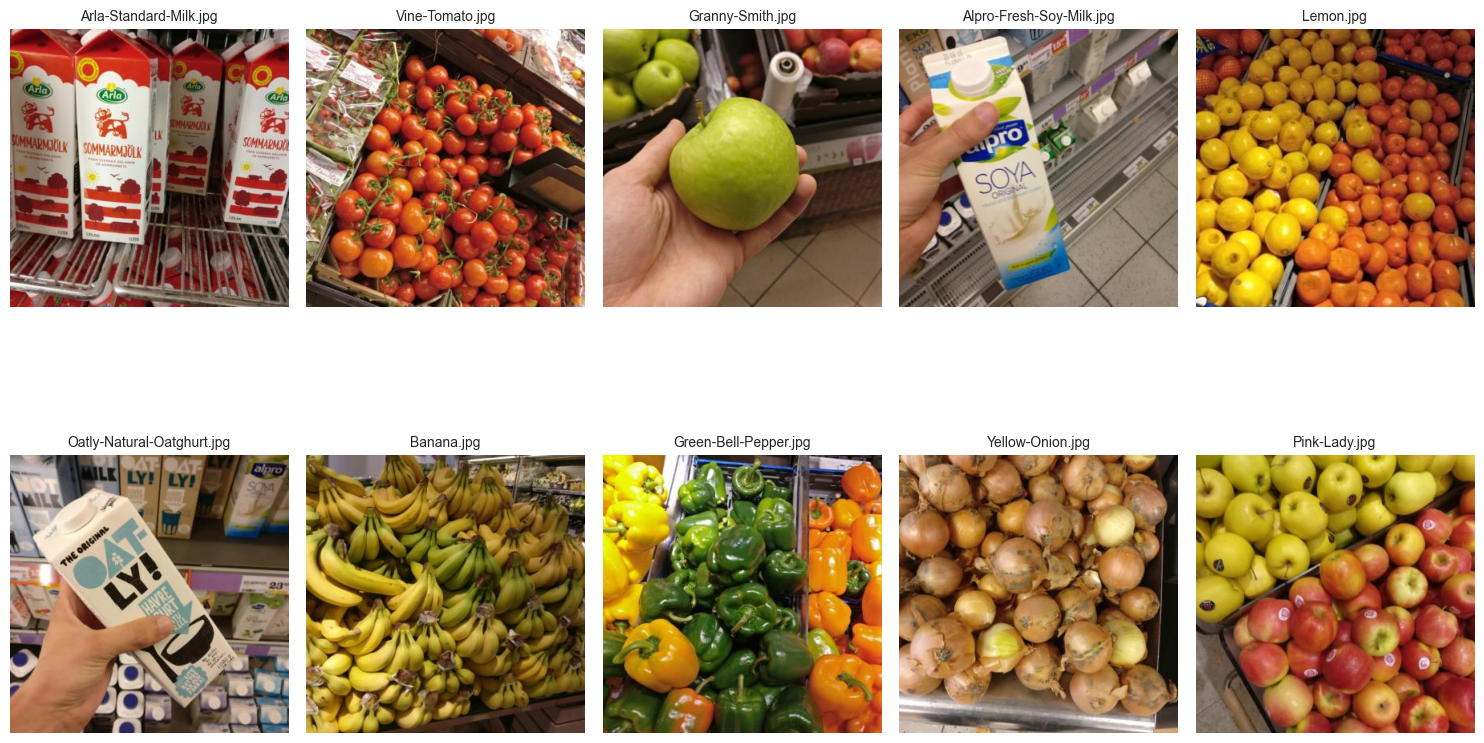

In [ ]:
sample_images_path = 'GrocerystoreDataset-master/sample_images/natural'

# Function to display 10 sample images
def display_sample_images(sample_images_path, num_images=10):
    # List all image files in the directory (and subdirectories)
    all_images = []
    for root, dirs, files in os.walk(sample_images_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, file))
    
    # Randomly select the desired number of images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Plot selected images
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # Adjust grid for 10 images
        plt.imshow(img)
        plt.title(os.path.basename(img_path), fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 sample images
display_sample_images(sample_images_path, num_images=10)


As you can see above are 10 sample natural images from the dataset as an example, with their category and names.

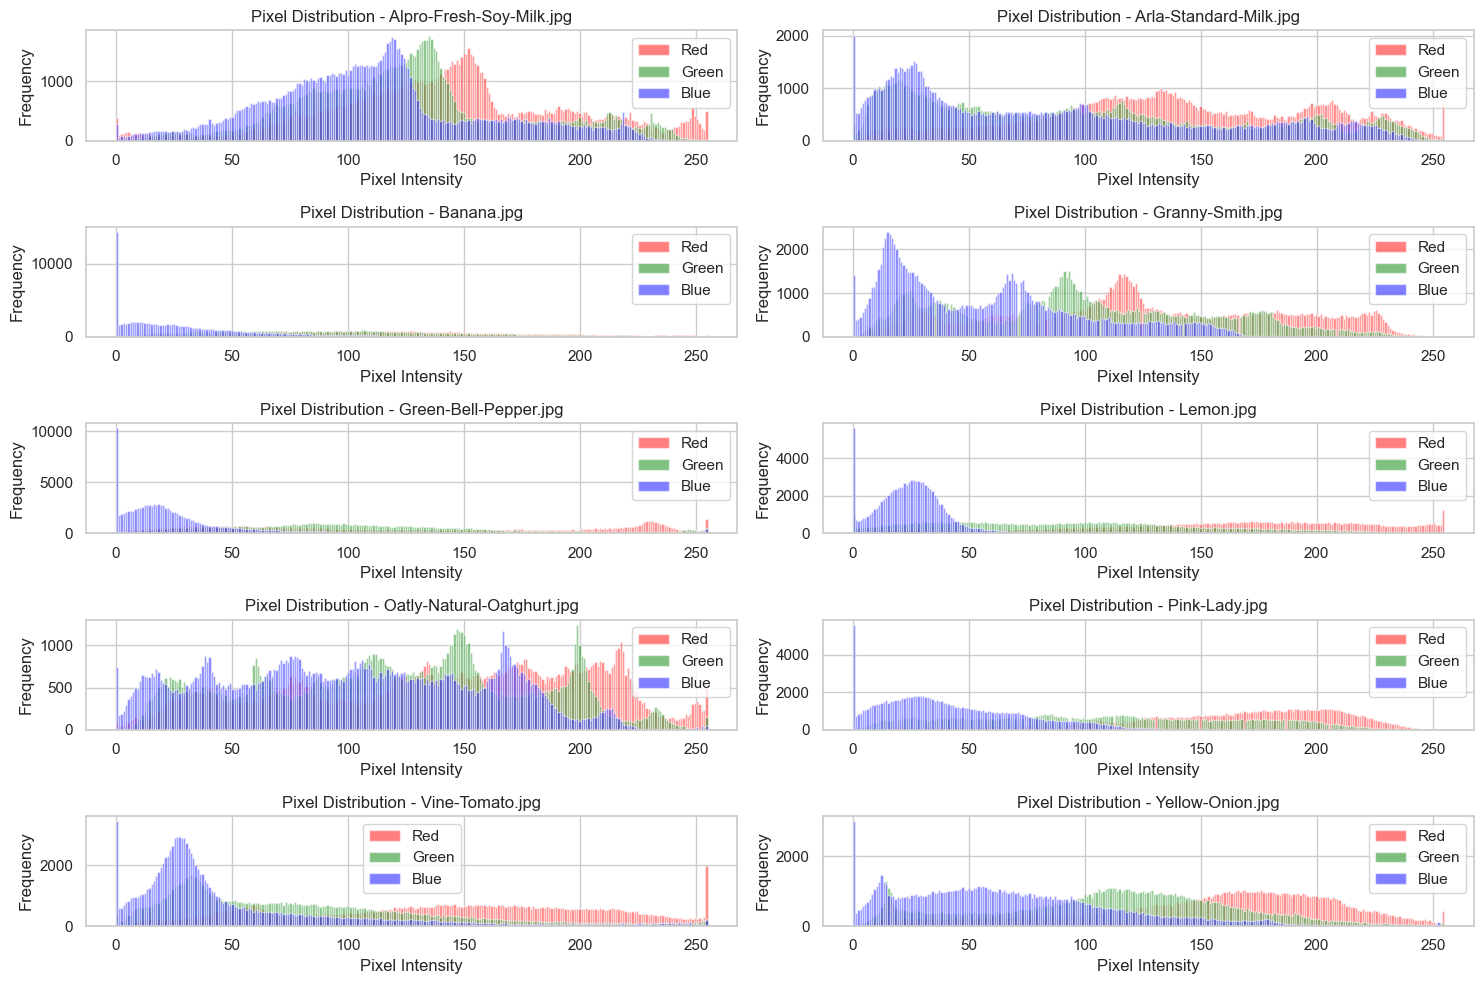

In [ ]:
# List image files in the directory
image_files = [os.path.join(sample_images_path, f) for f in os.listdir(sample_images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select 10 images
selected_images = image_files[:10]

# Plot pixel distributions
plt.figure(figsize=(15, 10))

for idx, image_path in enumerate(selected_images):
    # Open and convert the image to RGB format
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)

    # Flatten pixel values for all channels
    red_channel = img_array[:, :, 0].flatten()
    green_channel = img_array[:, :, 1].flatten()
    blue_channel = img_array[:, :, 2].flatten()

    # Plot histograms
    plt.subplot(5, 2, idx + 1)
    plt.hist(red_channel, bins=256, color='red', alpha=0.5, label='Red')
    plt.hist(green_channel, bins=256, color='green', alpha=0.5, label='Green')
    plt.hist(blue_channel, bins=256, color='blue', alpha=0.5, label='Blue')
    plt.title(f'Pixel Distribution - {os.path.basename(image_path)}')  # Show the file name in the title
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

1. Pixel Distribution as a Feature:
The distribution of pixel values in an image reflects important characteristics of the image, such as:

* Brightness: The overall intensity of the image (how light or dark it is).
* Contrast: The variation in pixel intensities (how sharp the features in the image are).
* Texture: The pattern and arrangement of pixel values (e.g., smooth surfaces or rough textures).

For example: Fruits like apples or tomatoes might have a uniform or consistent pixel distribution, while fruits like grapes might have a more varied distribution due to the small details in their texture. By using the histogram of pixel values (or other statistical methods), we can capture these characteristics and turn them into features for classification.

2. RGB Channels as Features:
Images are typically represented in RGB (Red, Green, Blue) channels, where each pixel has three values: one for each color channel. By analyzing the distribution of these values across an image, we can extract even more discriminative features:

* Color Dominance: For example, red apples would have a higher distribution of red values in their RGB channels, whereas green vegetables would have a more dominant green channel.
* Color Histograms: By splitting the image into its R, G, and B components and calculating their individual histograms, you can capture the specific color distribution of the image.

### 3.6 Study Correlations betweeen features

**RGB Color Correlation**

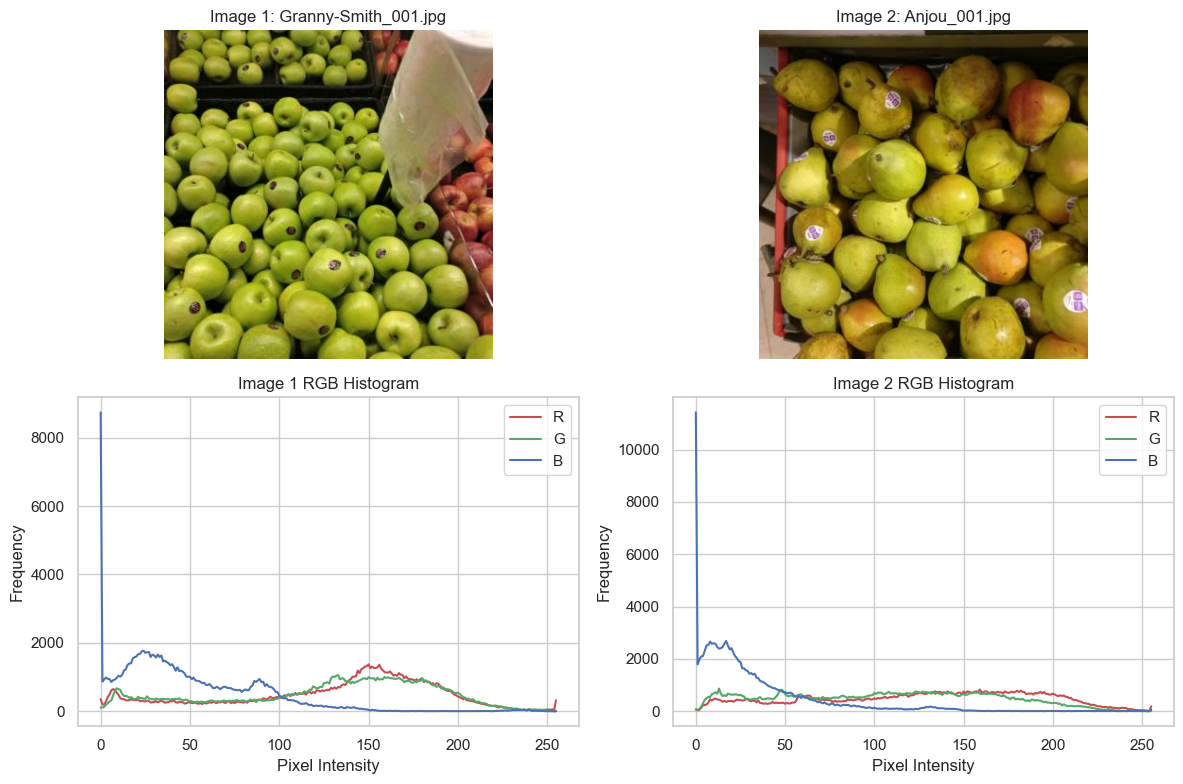

In [ ]:
# Function to compute RGB histograms
def compute_rgb_histogram(image_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate histogram for each channel
    color = ('r', 'g', 'b')
    histograms = {}
    for i, col in enumerate(color):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        histograms[col] = hist
    return histograms, image

# Function to visualize images and their histograms
def visualize_images_and_histograms(image1_path, image2_path):
    # Compute histograms and load images
    hist1, img1 = compute_rgb_histogram(image1_path)
    hist2, img2 = compute_rgb_histogram(image2_path)

    # Create a figure for visualization
    plt.figure(figsize=(12, 8))
    
    # Display the first image
    plt.subplot(2, 2, 1)
    plt.imshow(img1)
    plt.title("Image 1: " + os.path.basename(image1_path), fontsize=12)
    plt.axis("off")
    
    # Display RGB histogram for Image 1
    plt.subplot(2, 2, 3)
    for color, hist in hist1.items():
        plt.plot(hist, color=color)  # Use the respective color for the channel
    plt.title("Image 1 RGB Histogram", fontsize=12)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend(['R', 'G', 'B'])
    
    # Display the second image
    plt.subplot(2, 2, 2)
    plt.imshow(img2)
    plt.title("Image 2: " + os.path.basename(image2_path), fontsize=12)
    plt.axis("off")
    
    # Display RGB histogram for Image 2
    plt.subplot(2, 2, 4)
    for color, hist in hist2.items():
        plt.plot(hist, color=color)  # Use the respective color for the channel
    plt.title("Image 2 RGB Histogram", fontsize=12)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend(['R', 'G', 'B'])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Paths to images
image1_path = "GroceryStoreDataset-master\\dataset\\train\\Fruit\\Apple\\Granny-Smith\\Granny-Smith_001.jpg"
image2_path = "GroceryStoreDataset-master\\dataset\\train\\Fruit\\Pear\\Anjou\\Anjou_001.jpg"

# Visualize the images and their histograms
visualize_images_and_histograms(image1_path, image2_path)

**What Does the Code Show?**
- Images and Their Histograms:
The code displays two images side by side.
Below each image, it shows the RGB histogram, which represents the color distribution in that image.

- What the Histograms Represent:
Each channel (Red, Green, Blue) in the histogram shows how much of that color is present at different intensities (from dark to bright).
Peaks in the histogram tell us which colors dominate the image:
For example, a red apple will have a high peak in the red channel.

- Overlap in Histograms:
Granny Smith apples and pears both have a strong green channel because they share a similar color profile.
Their RGB histograms might look similar, especially in the green channel, but there could still be subtle differences:
Apples might have a slightly higher contribution from the red channel due to color gradients or lighting.
Pears might have a smoother distribution in the green channel due to their surface texture.

**Challenge for Classification:**
Since the color features in these two images overlap, color alone may not be enough to classify these items accurately.

**Edge Detection**

Lets explore another way to differentiate between these images

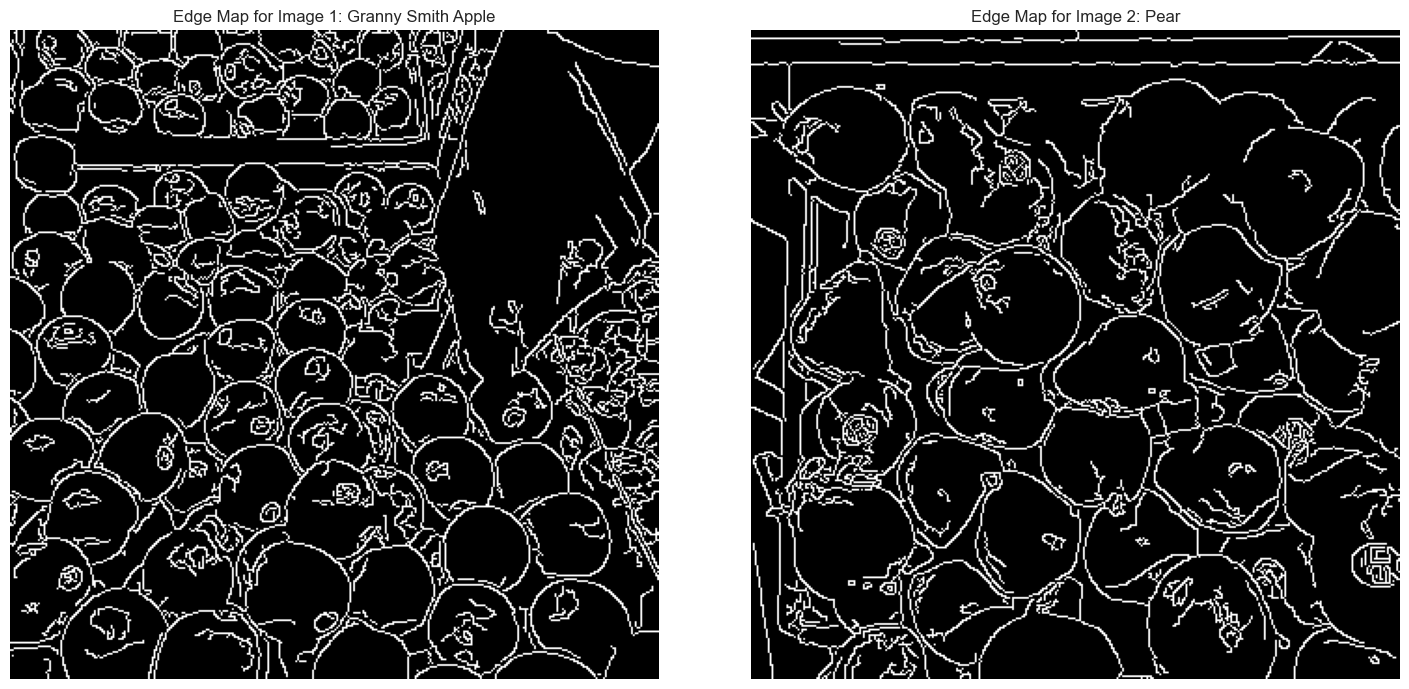

In [ ]:
# Function to compute edge map using Canny Edge Detection
def compute_edge_map(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale for edge detection
    edges = cv2.Canny(image, threshold1=50, threshold2=150)  # Canny edge detection
    return edges

# Function to display edge maps for two images
def display_edge_maps(image1_path, image2_path):
    # Compute edge maps
    edges1 = compute_edge_map(image1_path)
    edges2 = compute_edge_map(image2_path)
    
    # Plot edge maps
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    axes[0].imshow(edges1, cmap="gray")
    axes[0].set_title("Edge Map for Image 1: Granny Smith Apple")
    axes[0].axis("off")
    
    axes[1].imshow(edges2, cmap="gray")
    axes[1].set_title("Edge Map for Image 2: Pear")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Display edge maps
display_edge_maps(image1_path, image2_path)

**What This Does:**
- Canny Edge Detection: This function converts the image to grayscale and then applies the Canny edge detection algorithm, which highlights the boundaries and shapes in the image.

- Display Edge Maps: This code compares the edge maps of two images (Granny Smith apple and Anjou pear), showing how the shapes and boundaries differ between the images.

**Why use this?:**

- Color alone may not be sufficient for differentiating between objects like apples and pears, especially when the colors are similar (e.g., both having a lot of green).

- Edge detection focuses on shapes, boundaries, and contours in the image. It allows us to capture the structural features of the objects, like the roundness of an apple or the texture of a pear's skin.

Example: Even if the colors are similar (both have green tones), their shapes will differ:
- Apples are typically rounder, while pears often have a more tapered or elongated shape.
- Edge detection highlights these structural differences and can help the model distinguish between objects that might be hard to tell apart based on color alone.

**Feature Correlations Summary**

- Edge detection enhances the ability to detect structural differences between images, making it easier for the model to differentiate objects based on shape and texture, rather than just color.

- It’s especially helpful when objects have similar colors or are affected by external factors like lighting, which may change their appearance but not their structure.

- Combining color information (like histograms) with edge information allows the model to capture a broader spectrum of features, improving its ability to classify and differentiate similar objects.

### 3.7 Data transformations
**Transformations Less Relevant for Image Data**
- Logarithmic, Square Root, and Box-Cox Transformations
- Statistical Normalization (= Standard Scaling)
Reason: For image data, transformations like standard scaling (mean of 0 and std of 1) or logarithmic transformations used to achieve symmetrical distributions can be problematic because they can disrupt the inherent relationships and visual patterns in the image data that are critical for accurate image processing and recognition.

Here are a few ways applying these transformations might negatively affect image data processing:
* Loss of Relative Intensity Information:

    Example: Consider an image classification task to distinguish between daytime and nighttime scenes. Daytime images typically have higher average pixel intensities (brightness) compared to nighttime images. Standard scaling could normalize these differences, making it difficult for a model to use overall brightness as a distinguishing feature.

* Alteration of Color Relationships:

    Example: In tasks where color is a critical identifier, such as classifying traffic lights or flowers, the relative intensities and distributions of the RGB channels convey important information. Standard scaling each channel independently to have zero mean and unit variance could misalign these relationships, potentially leading to misclassifications or loss of discriminative power.

* Distortion of Image Content:

    Example: Applying a logarithmic transformation to normalize pixel value distributions can disproportionately enhance the visibility of darker areas while compressing the scale of brighter areas. This could be detrimental in medical imaging (e.g., X-rays or MRI scans), where the precise range of pixel intensities is crucial for identifying subtle anomalies.


**Relevance (or more like non-relevance) of Standard Scaling in Image Classification**

- Non-reliance on Distance Metrics:

    Most advanced image classification tasks today rely on Convolutional Neural Networks (CNNs) or similar deep learning models. These models do not explicitly calculate distances between input data points in their raw form, as methods like k-Nearest Neighbors (k-NN) or k-Means clustering do. Instead, CNNs apply filters to extract features and use non-linear activation functions to capture complex patterns in the data.
    In such models, the emphasis is less on the scale of individual pixel values regarding their distance to one another and more on how these values represent features like edges, textures, or color gradients. - Which is explored in the section 3.6

- Feature Normalization in CNNs:

    While standard scaling (zero mean and unit variance) per feature across the dataset is common in structured data, image data often benefits from simpler forms of scaling. A typical practice in image processing for CNNs is simply scaling pixel values to a [0, 1] range by dividing by 255 (the maximum pixel value for standard 8-bit images).
    This form of scaling helps to standardize the input data and aids in stabilizing the training process by keeping the numerical values small and manageable, which is particularly important for the gradient descent optimization algorithm used in training deep networks.

**Conclusion:** We will apply pixel value scaling to the [0, 1] range as our primary transformation method. This technique seems promising in ensuring faster and more stable convergence* of neural networks. Scaling pixel values to a normalize range of 0 and 1 prevents uneven weight updates during training, which can otherwise lead to inefficiencies and slow convergence rates.

*Convergence = The process by which the algorithm iteratively adjusts the model parameters (typically the weights) to minimize or reduce the loss function to its lowest possible value. Convergence is an indication that the model is effectively learning the underlying pattern in the data and is reaching a point where further training will not significantly improve its performance.





## 4. Prepare the data

Work on copies of the data (keep the original dataset intact).

In [ ]:
# Define original and working dataset paths
original_dataset_path = 'GroceryStoreDataset-master/'
working_dataset_path = 'GroceryStoreDataset-working/'

# Function to copy the dataset
def copy_dataset(original_path, working_path):
    if not os.path.exists(working_path):
        shutil.copytree(original_path, working_path)
        print(f"Dataset copied successfully to: {working_path}")
    else:
        print(f"Working dataset already exists at: {working_path}")

copy_dataset(original_dataset_path, working_dataset_path)

# Verify the contents of the copied dataset
copied_contents = os.listdir(working_dataset_path)
print("Copied dataset contents:", copied_contents)

Working dataset already exists at: GroceryStoreDataset-working/
Copied dataset contents: ['dataset', 'LICENSE', 'README.md', 'sample_images']


#### 4.1 Data cleaning
We will look at the outliers in respect to the image size.

In [ ]:
# Let's create a DataFrame that will hold the image file paths, names, sizes, and dimensions
# Function to read image paths from a text file
def read_image_paths(file_path):
    with open(file_path, 'r') as f:
        return [line.strip().split(',')[0] for line in f if line.strip()]
# Gather all image paths from the train, validation, and test datasets
image_paths = []
image_paths.extend(read_image_paths(train_file))
image_paths.extend(read_image_paths(val_file))
image_paths.extend(read_image_paths(test_file))

# Collect file sizes and names
file_sizes = []
file_paths = []
file_names = []
dimensions = []
base_path = 'GroceryStoreDataset-working/dataset/'
for file_path in image_paths:
    full_path = os.path.join(base_path, file_path)
    if file_path.endswith(('.png', '.jpg', '.jpeg')):
        try: 
            size_kb = os.path.getsize(full_path) / 1024  # Convert to Kilobytes
            file_sizes.append(size_kb)
            file_paths.append(full_path)
            file_names.append(os.path.basename(file_path))

            # Open image and get dimensions
            with Image.open(full_path) as img:
                dimensions.append(f"{img.width}x{img.height}")
        except FileNotFoundError:
            print(f"File not found: {full_path}")
            continue

# Create a dataframe to hold the image info
file_sizes_df = pd.DataFrame({
    'File Path': file_paths,
    'File Name': file_names,
    'File Size (KB)': file_sizes,
    'Dimensions': dimensions    # Dimensions will be used later on
})

KeyboardInterrupt: 

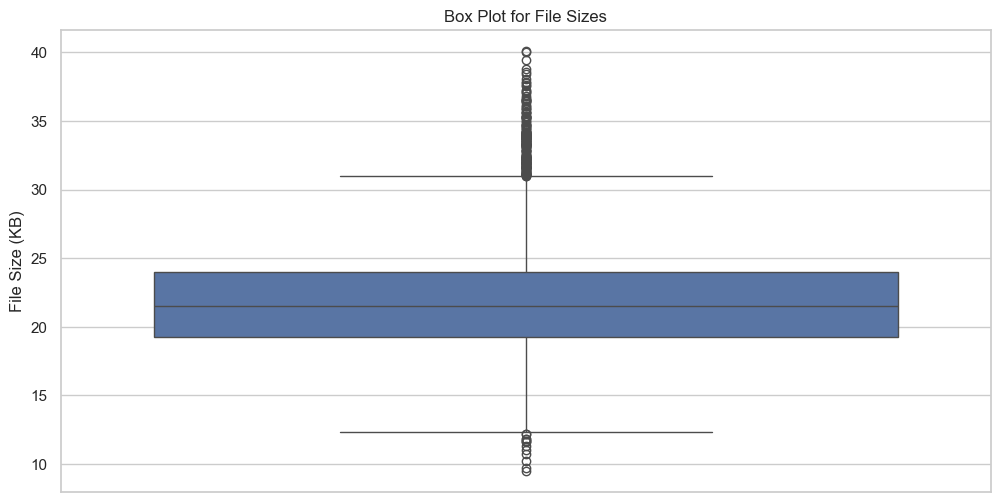

In [ ]:
# Display the box plot for file sizes to see the outliers
plt.figure(figsize=(12, 6))
sns.boxplot(y=file_sizes_df['File Size (KB)'])
plt.title('Box Plot for File Sizes')
plt.ylabel('File Size (KB)')
plt.show()


In [ ]:
# Calculate Q1, Q3, and IQR
Q1 = file_sizes_df['File Size (KB)'].quantile(0.25)
Q3 = file_sizes_df['File Size (KB)'].quantile(0.75)
IQR = Q3 - Q1

# Calculate upper bounds for outliers using the typical 1.5 * IQR beyond the quartiles
upper_bound = Q3 + 1.5 * IQR

# Filter the images for any entries beyond the bounds, effectively identifying the outliers
outliers = file_sizes_df[(file_sizes_df['File Size (KB)'] > upper_bound)]

# Print outliers
print("Outlier files (based on box plot criteria):")
display(outliers.head())
display(outliers.shape)

Outlier files (based on box plot criteria):


File Path             File Name  \
53   GroceryStoreDataset-working/dataset/train/Frui...  Granny-Smith_009.jpg   
75   GroceryStoreDataset-working/dataset/train/Frui...  Granny-Smith_031.jpg   
86   GroceryStoreDataset-working/dataset/train/Frui...  Granny-Smith_042.jpg   
95   GroceryStoreDataset-working/dataset/train/Frui...  Granny-Smith_051.jpg   
280  GroceryStoreDataset-working/dataset/train/Frui...       Avocado_003.jpg   

     File Size (KB)  
53        33.313477  
75        33.094727  
86        31.888672  
95        32.851562  
280       33.666992

(184, 3)

184 images were identified as the upper bound outliers. We disregarded the lower bound ones as the issue is caused by images with large size. 
The file size of these outliers is 31-40 kB in comparison to the images in the interquantile range where the image size is between 19 and 24 kB.

Next, we will take a look at the upper bound outliers. We'll display 15 images.

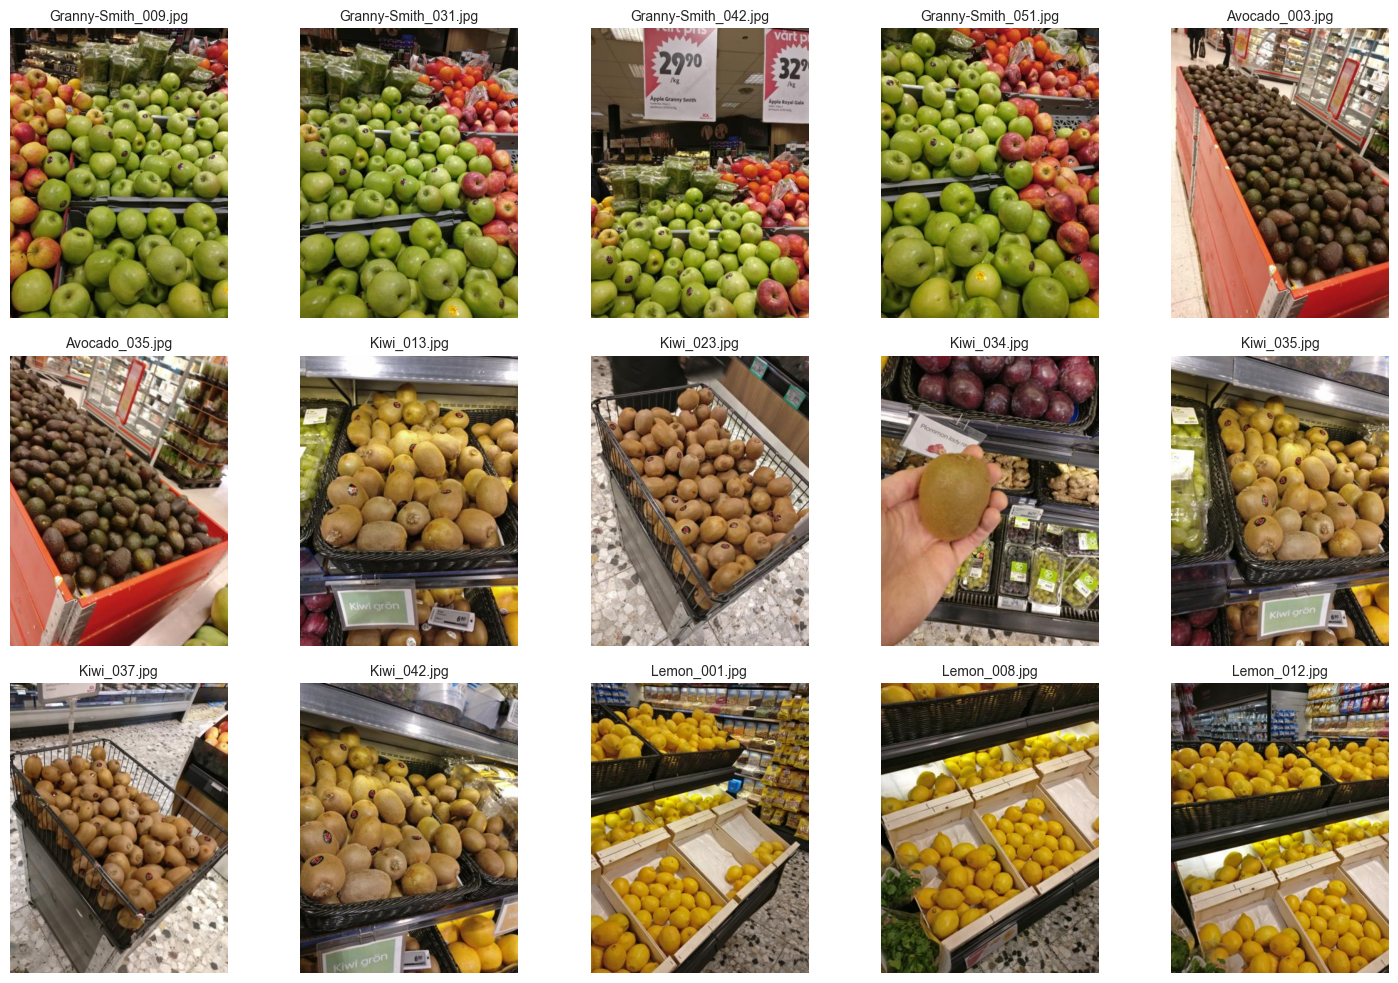

In [ ]:
# Plot selected images
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(outliers['File Path'][:15]):
    img = Image.open(img_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

After careful consideration, we have decided not to take any action on these outliers. The detected outliers do not necessarily represent incorrect or invalid data. As it turns out from the analysis above, larger file sizes still provide valuable information for training the model. Removing or altering these outliers could risk discarding valid and potentially meaningful examples, which could inadvertently reduce the model's ability to generalize.
What is more relevant to our objective is the process of cropping and resizing images to the desired size and aspect ratio. This step might also influence the file sizes, rendering the above-mentioned consideration of outliers as less critical. We will further explore the techniques of cropping and resizing in Section 4.3 on Feature Engineering.

#### 4.2 Feature Selection

Negative effect of removing features from the images:

- Essential Features: Color, shape, and other visual characteristics are crucial for differentiating between products. Removing these features could negatively impact the model's ability to accurately classify items.

- Risk of Increased Errors: Removing certain features increases the likelihood of errors in classification. Every feature contributes to the model's understanding of the image.

- Background Noise: While background noise may seem unnecessary, which can help the model recognize products in various environments. Removing background elements could reduce the model’s robustness, making it less adaptable to real-world settings, where noise is common. In certain situations where the background is overwhelmingly noisy or fills too much space, then it would be necessary to remove the background.

In Conclusion, Although there is potential for too much background noises in the images we currently have in our dataset. We will be moving forward without making and changes to the background or other features in the images.

#### 4.3 Feature engineering
Elaboration of the suggested steps:

##### 4.3.1 Discretizing Continuous Features

Discretization is more common in tabular datasets with numerical features (e.g., income levels or ages). In our case, the dataset primarily consists of image data and categorical metadata, making this technique less relevant.

##### 4.3.2 Using One-Hot Encoding

One-hot encoding could be relevant when handling categorical metadata, such as "Class Name" or "Category Name." For example, if we include metadata alongside image features (e.g., combining "Juice" with its corresponding image), one-hot encoding ensures the model can interpret these categories numerically. We can use it for converting categorical variables (class names such as "Granny Smith") into binary vectors for classification tasks.

##### 4.3.3 Aggregating Features into Promising New Features

For image features extracted using CNNs, aggregation is usually unnecessary since the CNN itself learns hierarchical feature representations. We could potentially use it in a more advanced model where we integrate metadata (e.g., class and category names), and aggregate features hierarchically:

Combining "Granny Smith" and "Golden Delicious" under "Apple."
Aggregating fruit categories ("Apple", "Banana", etc.) into a broader "Fruit" group.



##### 4.3.4 Dimension reduction
The following section focuses on the cropping and resizing the images to the desired size and aspect ratio.
Let's double-check the image dimensions to see if they are the same.

In [ ]:
unique_dimensions = file_sizes_df['Dimensions'].nunique()

# Print the number of unique dimensions
print(f"Number of unique dimensions: {unique_dimensions}")

# Print out what these dimensions are and how many images there are for each dimension
dimension_counts = file_sizes_df['Dimensions'].value_counts()
print("Count of images per dimension:")
print(dimension_counts)

Number of unique dimensions: 3
Count of images per dimension:
Dimensions
348x348    4958
348x464     426
464x348      37
Name: count, dtype: int64


The image dimensions are not aligned. This observation is not ideal as it is crucial for CNN architectures to receive input images of the same dimensions. This means we have to crop and resize the images to the desired size and aspect ratio. 

We used an external function to do that.

This what the FeatherVision guys did - it seems perfect for this use case (it's from 3. Data preparation):
<p>The main goal of the project is to enable the user to upload a picture of the bird and the model will identify the species. In the first steps the model is trained on the data in the existing dataset. This dataset contains images of predefined size with an aspect ratio of 1. This means that in order to use custom pictures, they have to be cropped and resized to the desired size and aspect ratio. </p>
<p>The function shown below aims to do exactly that. It uses a pre-trained Faster R-CNN model trained on the COCO dataset to identify a bird in the provided picture. The screenshot below shows a part of supported objects with their IDs. When the bird is identified (output label is 16, ID of a bird), size of a bounding box is established and the bird in the picture is cropped. The size of the box can be adjusted by changing the padding value. Another parameter that can be adjusted is how the bird is identified in the picture. By default, the pre-trained model chooses the prediction with the highest confidence score. If the useLargestBird argument is set to true, the model will pick the largest identified bird in the picture, which might be useful when there's multiple recognized objects.</p> 
<p> At this point, the image still has the wrong aspect ratio, so it is resized using the Lanczos resampling filter. (https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-filters) This action, however, distorts the bird, which might affect the accuracy of the species identification. </p> 
<p>Another way of handling the distortion when resizing images is to add 'zero padding' - borders of pixels with a value of zero (black) around an image to reach the desired size while keeping the aspect ratio. By setting showOutput=True in the detect_birds() method, all the versions of the entered picture are shown.</p>

In [ ]:
# NOTE from Petra: DOES NOT WORK
from utils import detect_items, load_image_from_path

image_path = "GroceryStoreDataset-working/dataset/test/Fruit/Avocado/Avocado_001.jpg"

# if os.path.exists(image_path):
    # image = load_image_from_path(image_path)
    # if image is not None:
        # detect_items(image)

UnboundLocalError: cannot access local variable 'resized_image' where it is not associated with a value

#### 4.4 Feature scaling - pixel transformation
Maybe relevant, maybe not. Who knows? 

In [ ]:
'''
dataset_path = os.path.join('GroceryStoreDataset-working')
os.listdir(dataset_path)

# Inspect the dataset directory
dataset_dir = os.path.join(dataset_path, 'dataset')
os.listdir(dataset_dir)

# Function to resize images in a given directory
def resize_images_in_directory(input_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, relative_path)
                output_dir_path = os.path.dirname(output_path)

                # Create directories if not existing
                if not os.path.exists(output_dir_path):
                    os.makedirs(output_dir_path)

                # Open, resize, and save the image
                with Image.open(input_path) as img:
                    resized_img = img.resize(size)
                    resized_img.save(output_path)

# Paths to train, val, and test directories
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Output directories for resized images
resized_dir = os.path.join(dataset_dir, 'resized_images')
train_resized_dir = os.path.join(resized_dir, 'train')
val_resized_dir = os.path.join(resized_dir, 'val')
test_resized_dir = os.path.join(resized_dir, 'test')

# Resize images to 348x348
target_size = (348, 348)
resize_images_in_directory(train_dir, train_resized_dir, target_size)
resize_images_in_directory(val_dir, val_resized_dir, target_size)
resize_images_in_directory(test_dir, test_resized_dir, target_size)

# Confirm the resizing process for one directory
os.listdir(train_resized_dir)
'''


['Fruit', 'Packages', 'Vegetables']

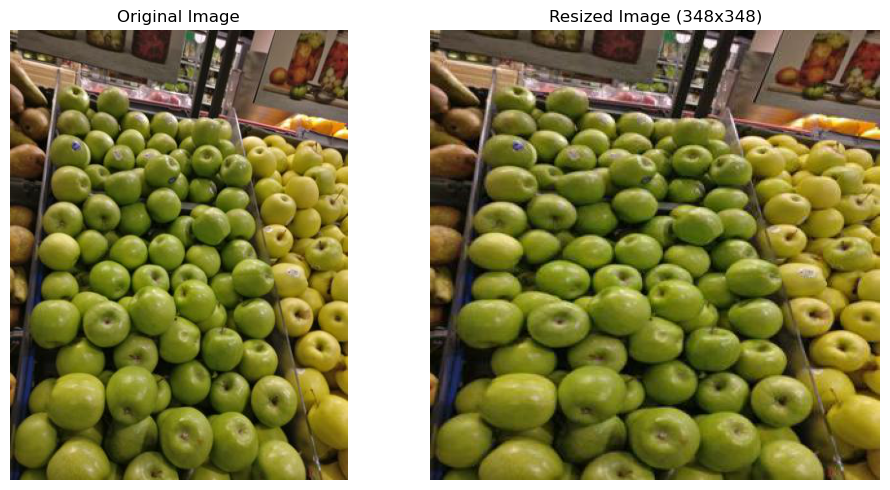

In [10]:
dataset_dir = 'GroceryStoreDataset-master/dataset'
os.listdir(dataset_dir)
resized_dir = 'GroceryStoreDataset-working/dataset'

# Paths to original and resized images
original_image_path = os.path.join(dataset_dir, 'test', 'Fruit', 'Apple', 'Granny-Smith', 'Granny-Smith_031.jpg')
resized_image_path = os.path.join(resized_dir, 'test', 'Fruit', 'Apple', 'Granny-Smith', 'Granny-Smith_031.jpg')

# Open the original and resized images
original_image = Image.open(original_image_path)
resized_image = Image.open(resized_image_path)

# Display side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(resized_image)
axes[1].set_title("Resized Image (348x348)")
axes[1].axis("off")

plt.tight_layout()
plt.show()
